Data loaded successfully.
Data shape: (768, 9)
Columns: Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
Model accuracies:
Logistic Regression: 0.7512 ± 0.0198
SVM: 0.7575 ± 0.0127
Decision Tree: 0.6820 ± 0.0299
Naive Bayes: 0.7603 ± 0.0227
MLP: 0.6771 ± 0.0341


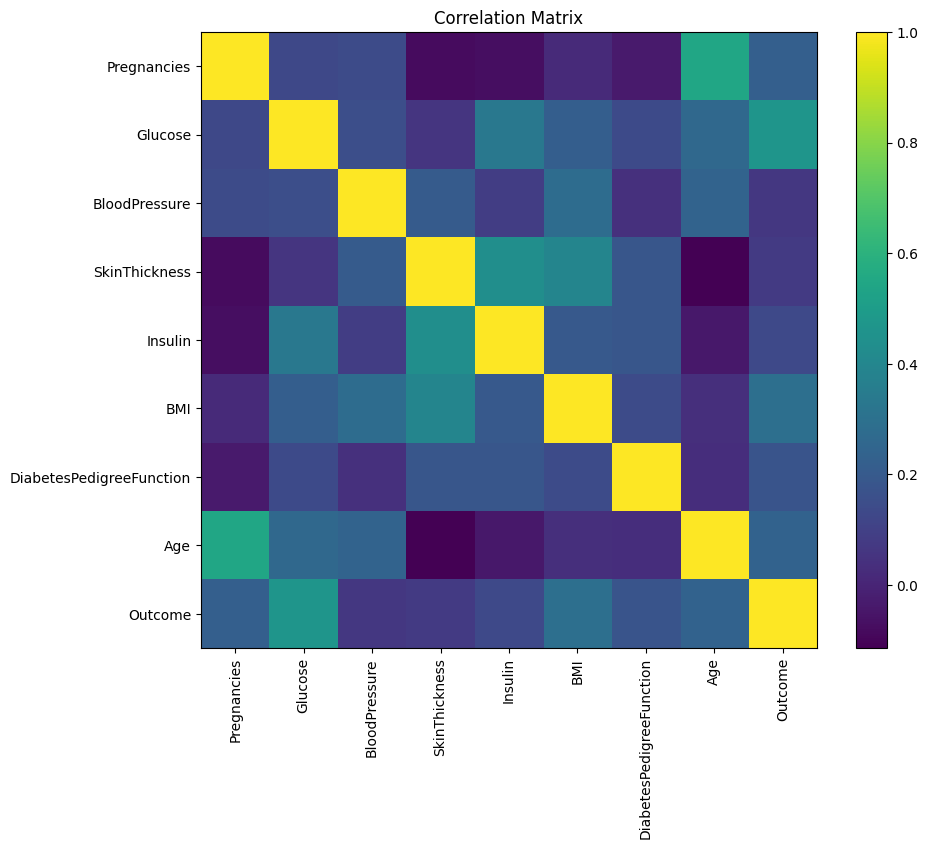

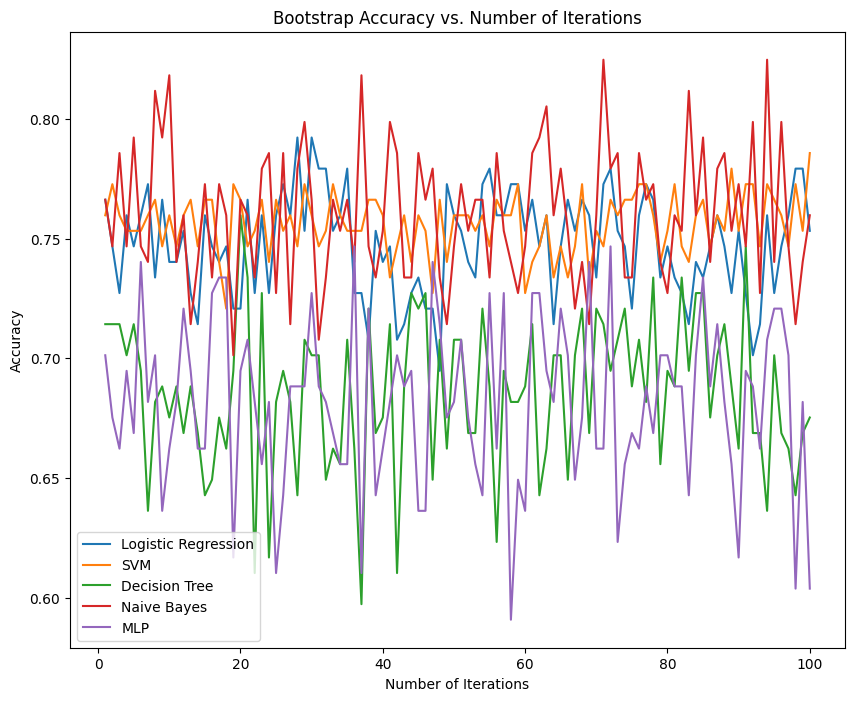


Accuracy and Uncertainty:
                     Accuracy  Uncertainty
Logistic Regression  0.751169     0.019843
SVM                  0.757532     0.012666
Decision Tree        0.682013     0.029947
Naive Bayes          0.760260     0.022731
MLP                  0.677078     0.034100

Error Rates:
                          MAE      RMSE
Logistic Regression  0.253247  0.503236
SVM                  0.233766  0.483494
Decision Tree        0.240260  0.490163
Naive Bayes          0.233766  0.483494
MLP                  0.324675  0.569803


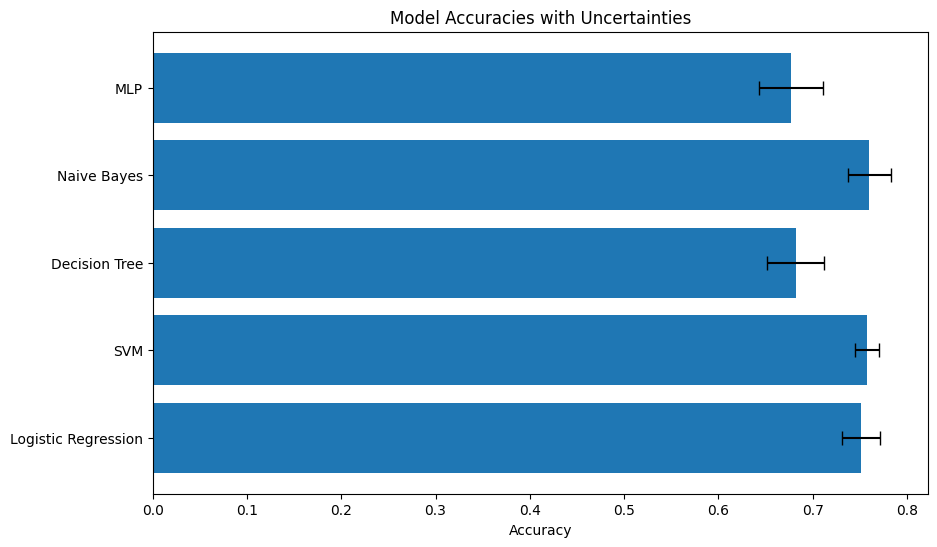

<Figure size 1000x600 with 0 Axes>

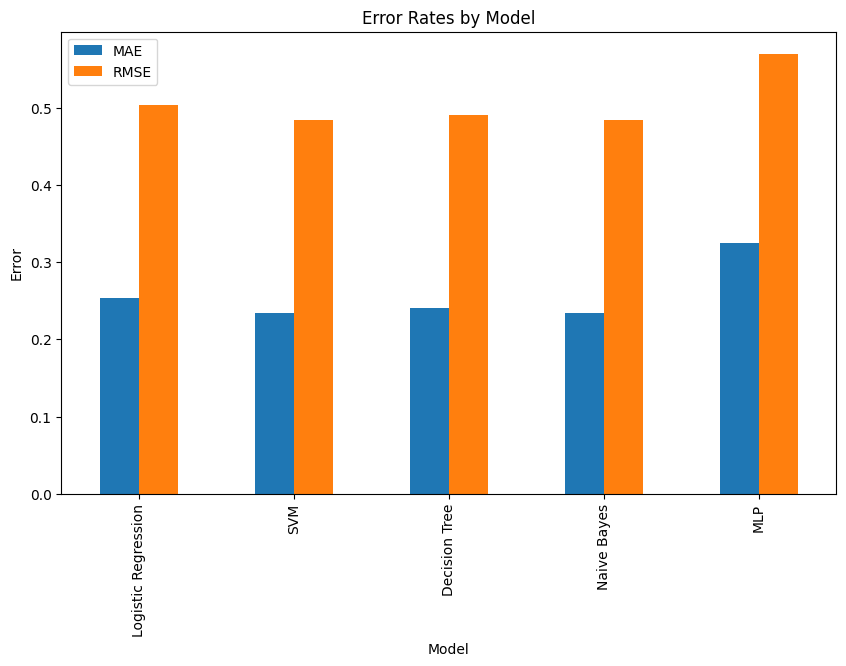

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# Load data
df = pd.read_csv('/content/diabetes.csv')

# Check data integrity
print('Data loaded successfully.')
print('Data shape:', df.shape)
print('Columns:', df.columns)

# Check for missing values
print(df.isnull().sum())

# Fill missing values with zeros
df.fillna(0, inplace=True)

# Splitting the data into features and labels
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_reg = make_pipeline(SimpleImputer(strategy='mean'), LogisticRegression(max_iter=1000))
svm = make_pipeline(SimpleImputer(strategy='mean'), SVC())
decision_tree = DecisionTreeClassifier()
naive_bayes = GaussianNB()
mlp = MLPClassifier(max_iter=1000)

models = [
    ('Logistic Regression', log_reg),
    ('SVM', svm),
    ('Decision Tree', decision_tree),
    ('Naive Bayes', naive_bayes),
    ('MLP', mlp)
]

# Bootstrapping function
def bootstrap(model, X_train, y_train, X_test, y_test, n_iterations=100):
    accuracies = []
    for _ in range(n_iterations):
        X_boot, y_boot = resample(X_train, y_train)
        model.fit(X_boot, y_boot)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    return accuracies

# Results dictionary to store accuracies and uncertainties
results = {}
uncertainties = {}

# Bootstrap each model and calculate uncertainties
for name, model in models:
    model_accuracies = bootstrap(model, X_train, y_train, X_test, y_test)
    mean_accuracy = np.mean(model_accuracies)
    std_dev = np.std(model_accuracies)
    results[name] = mean_accuracy
    uncertainties[name] = std_dev

# Display results
print('Model accuracies:')
for model, acc in results.items():
    print(f'{model}: {acc:.4f} ± {uncertainties[model]:.4f}')

# Plot correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
plt.title('Correlation Matrix')
plt.imshow(corr_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(corr_matrix.columns))
plt.xticks(tick_marks, corr_matrix.columns, rotation=90)
plt.yticks(tick_marks, corr_matrix.columns)
plt.show()

# Plot Bootstrap Accuracy vs. Number of Iterations for each model
plt.figure(figsize=(10, 8))
plt.title('Bootstrap Accuracy vs. Number of Iterations')
for name, model in models:
    accuracies = bootstrap(model, X_train, y_train, X_test, y_test)
    plt.plot(range(1, len(accuracies)+1), accuracies, label=name)
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate error rates
error_rates = {}
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    error_rates[name] = {'MAE': mae, 'RMSE': rmse}

# Compare results in tabular format (Accuracy)
accuracy_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
uncertainty_df = pd.DataFrame.from_dict(uncertainties, orient='index', columns=['Uncertainty'])
accuracy_df = accuracy_df.join(uncertainty_df)
print('\nAccuracy and Uncertainty:')
print(accuracy_df)

# Compare error rates in tabular format
error_df = pd.DataFrame.from_dict(error_rates, orient='index')
print('\nError Rates:')
print(error_df)

# Draw plots for accuracy and error rate separately
plt.figure(figsize=(10, 6))
plt.barh(accuracy_df.index, accuracy_df['Accuracy'], xerr=accuracy_df['Uncertainty'], capsize=5)
plt.xlabel('Accuracy')
plt.title('Model Accuracies with Uncertainties')
plt.show()

plt.figure(figsize=(10, 6))
error_df.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Model')
plt.ylabel('Error')
plt.title('Error Rates by Model')
plt.legend(['MAE', 'RMSE'])
plt.show()
